# Predicting Heart Failure

Data Source: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
sns.set_style('darkgrid')
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

## Exploratory Data Analysis

In [48]:
# load data
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [49]:
# view data
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [50]:
df.shape

(299, 13)

There are 299 observations with 12 independent features and one dependent feature, mortality.

In [51]:
df.isnull().values.any()

False

There are no missing values in the data set.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


All data types are appropriate.

The binary variables are anemia, diabetes, high blood pressure, sex, smoking, and mortality during follow-up period. Since the target variable is binary, this will be a classification problem.

In [53]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


The data set only contains data for people over the age of 40, which should be taken into account when considering the applications of our models.

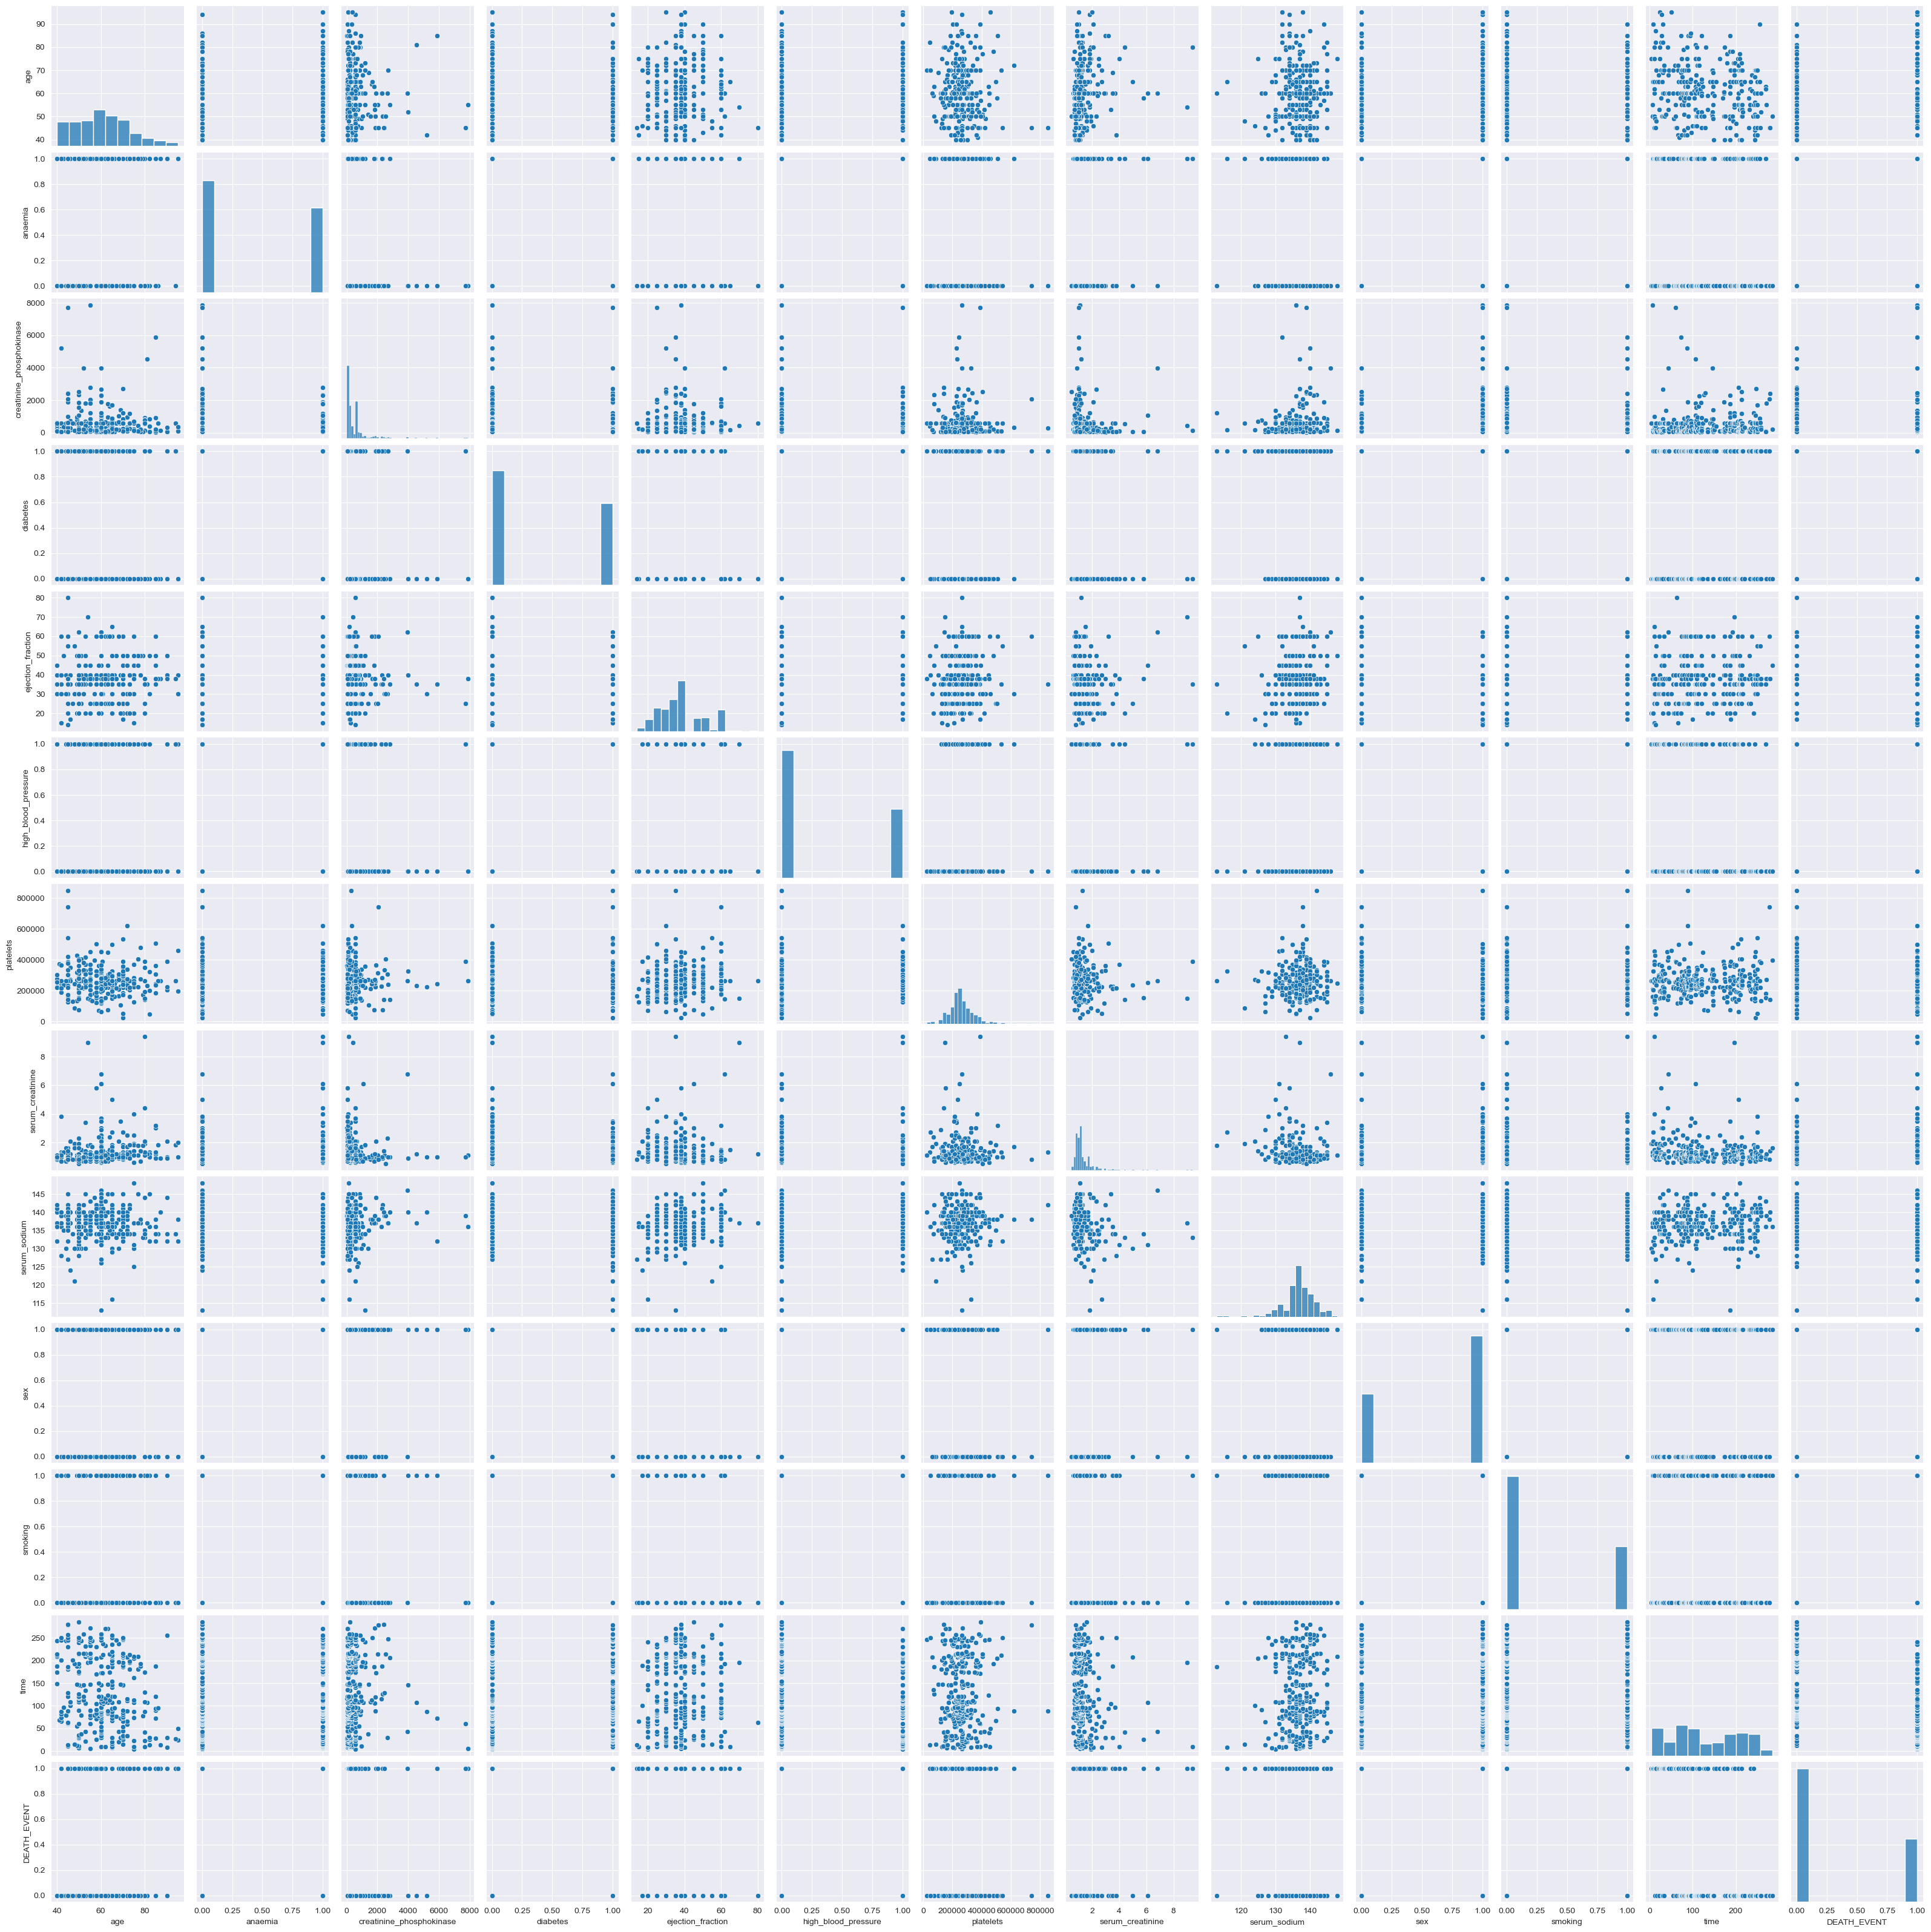

In [54]:
sns.pairplot(df)

From the pairplot, it does not seem like any two features are obviously correlated, meaning the features are likely not redundant.

In [55]:
df['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

32.1% of the observations are deaths, meaning that an algorithm that just predicted no mortality every time would be accurate 67.9% of the time. This imbalance should be kept in mind when evaluating the accuracy of the models.

## Support Vector Machine

In [56]:
#get the input features
x_feats = list(df.columns)
x_feats.remove('DEATH_EVENT')
X = df[x_feats]

#get the target
y = df['DEATH_EVENT']

#partition the data
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

In [57]:
features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'time']

#normalize the numeric features
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features]) #scale the training data

In [58]:
#view the prepared data
X_train.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
208,-0.025068,1,1.778526,1,0.135923,0,0.279060,-0.393842,141,0,0,0.749889
29,1.950834,0,-0.545981,1,-0.697153,0,-0.595300,-0.183672,132,1,1,-1.381278
280,0.873069,0,2.213780,1,0.135923,0,-0.163387,-0.393842,137,1,0,1.544113
163,-0.923205,1,1.834247,1,-0.280615,0,-1.912108,-0.498927,142,0,0,-0.057572
284,-0.923205,1,-0.562803,0,0.135923,0,0.236922,-0.604012,141,1,0,1.583824
144,1.052697,1,0.371836,0,-1.113690,1,0.858456,0.341752,139,1,1,-0.256128
158,2.220275,1,0.337142,0,0.968998,0,-0.226594,-0.078587,134,1,0,-0.123757
71,-0.204695,0,-0.007696,1,-0.280615,0,-1.416989,-0.498927,139,1,1,-0.785610
296,-1.372274,0,1.546180,1,1.802074,0,5.114379,-0.604012,138,0,0,1.954462
85,-0.833391,0,-0.537570,0,0.968998,0,1.574799,-0.709097,140,1,0,-0.679714


In [59]:
#initialize the classifier
svm = SVC() #the default kernel is rbf
svm.fit(X_train, y_train); #fit the data

# scale the test data
X_test[features] = \
scaler.transform(X_test[features])

#predict the labels for the test set
y_pred = svm.predict(X_test)

print('The predicted occurance of a death event is {}'.format(y_pred))

The predicted occurance of a death event is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [60]:
#evaluate the prediction accuracy
accuracy = svm.score(X_test, y_test)
print('The accuracy of the model is: {:.2f}'.format(round(accuracy, 2)))

The accuracy of the model is: 0.68


In [61]:
#setup the parameter grid to try values of c ranging from 0.1 to 10, and values for gamma ranging from .1 to 5.
params = {'C': np.arange(0.01, 10),
         'gamma': np.arange(0.01, 5)}

#initialize Grid Search with Cross Validation
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv = 5, return_train_score=True)
svm_grid.fit(X_train, y_train)

# print the best hyperparameters and score
print('Best hyperparameters:', svm_grid.best_params_)
print('Best score:', round(svm_grid.best_score_, 2))

Best hyperparameters: {'C': 3.01, 'gamma': 0.01}
Best score: 0.79


- C: This hyperparameter controls regularization strength, which determines how much the SVM model prioritizes margin (the distance between the decision boundary and the closest data points) over classification error. A smaller C value results in a wider margin and a simpler decision boundary, while a larger C value results in a narrower margin and a more complex decision boundary.I chose C values ranging from 0.1 to 10.

- gamma: This hyperparameter controls the kernel coefficient, which shapes the decision boundary. A smaller gamma value produces a more flexible decision boundary that fits complex datasets with many features, while a larger value may overfit the training data. I chose gamma ranging from 0.1 to 5. 

- The GridSearchCV function is used to perform a grid search with 5-fold cross-validation, and it turns out that when C is 3.01 and gamma is 0.01, this model produces the best results.

In [62]:
#display the cv results for the train and test set
cv_results = pd.DataFrame(svm_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
25,0.855261,0.013882,0.793844,0.046728
30,0.858847,0.016372,0.793844,0.051352
20,0.856459,0.013124,0.793844,0.046728
15,0.849266,0.014022,0.793844,0.046728
45,0.864842,0.009587,0.789082,0.048494


This accuracy score of 0.68 is not particularly high and suggests that the model is making a significant number of errors in its predictions. 

However, after performing hyperparameter tuning using GridSearchCV, I was able to increase the mean test score to 0.7938. This indicates that the hyperparameter tuning process helped to improve the performance of the model by finding a better combination of hyperparameters that allowed the model to better capture the underlying patterns in the data.

It is worth noting that the highest mean train score is 0.8553, while the highest mean test score is 0.7938. This suggests that there is some degree of overfitting in the model, as it is performing better on the training data than on the test data.

Overall, based on the table, it seems that the model is performing relatively averagely.

#### SVM model accuracy: 79.38%

## Random Forest Classification

In [63]:
# get list of feature names
x_feats = list(df.columns)
x_feats.remove('DEATH_EVENT')

#partition the data
X = df[x_feats]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [64]:
# establish parameter grid
params = {'max_depth': np.arange(1, 10, 2),
         'n_estimators': np.arange(50, 200, 50),
         'min_samples_split': np.arange(2, 5),
         'min_samples_leaf': np.arange(1, 30, 5),
         'bootstrap': [True, False]}

rfc = RandomForestClassifier(random_state=7)

#initialize grid search with cross validation
rfc_grid = GridSearchCV(estimator=rfc, param_grid=params, cv=5, return_train_score=True)
rfc_grid.fit(X_train, y_train)

# display best parameters and score
print(rfc_grid.best_params_)
print(rfc_grid.best_score_)

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 100}
0.8803716608594657


The best accuracy score was 88.04%

In [65]:
# display the cv results for the train and test set
cv_results = pd.DataFrame(rfc_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
121,0.916267,0.006563,0.880372,0.047633
118,0.916267,0.006563,0.880372,0.047633
124,0.916267,0.006563,0.880372,0.047633
178,0.921058,0.004378,0.875610,0.055085
117,0.916282,0.008309,0.875610,0.040912


The highest mean train score is 92.1% and the highest mean test score is 88.0%. These values are similar showing that the random forest classifier does not appear to overfit or underfit the data.

In [67]:
# initialize classifier with best parameters
rfc = RandomForestClassifier(random_state=7, max_depth=5, min_samples_leaf=6)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [69]:
print(classification_report(y_test, y_pred, target_names = ['death occurance', 'no death event']))

                 precision    recall  f1-score   support

death occurance       0.92      0.90      0.91        61
 no death event       0.80      0.83      0.81        29

       accuracy                           0.88        90
      macro avg       0.86      0.86      0.86        90
   weighted avg       0.88      0.88      0.88        90



Each time the model predicted death, it was correct 92% of the time. When the mdoel predicted no death, it was correct 80% of the time. Out of all actual deaths, the model predicted correctly 90% of the time. Out of actual non-deaths, the model predicted correctly 83% of the time. In the context of this problem, recall for death occurance is important because we want to succesfully identify those at risk of death in order to provide treatment. It is better to have a false positive than a false negative in this senario. 

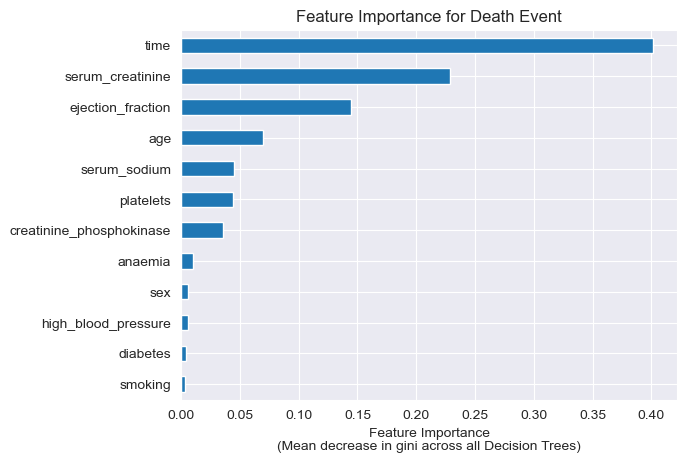

In [29]:
# create series of feature importance values
importances = list(rfc.feature_importances_)
importance_series = pd.Series(data=importances, index=x_feats)

# sort and plot features
importance_series = importance_series.sort_values()
importance_series.plot.barh()
plt.title('Feature Importance for Death Event')
plt.xlabel('Feature Importance\n(Mean decrease in gini across all Decision Trees)')
plt.show()

The time feature was the most significant. This represents the follow up period. Since this value is not able to be measuring during say a screening visit, the analysis will now be run with time excluded in order to better focus on the importance of the measurable features.

### Random forest excluding follow-up period

In [30]:
# remove time from features
new_feats = x_feats.copy()
new_feats.remove('time')

# partition the data
X = df[new_feats]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

In [31]:
# establish parameter grid
params = {'max_depth': np.arange(1, 10, 2),
         'n_estimators': np.arange(50, 200, 50),
         'min_samples_split': np.arange(2, 5),
         'min_samples_leaf': np.arange(1, 30, 5),
         'bootstrap': [True, False]}

rfc = RandomForestClassifier(random_state=7)

# initialize grid search with cross validation
rfc_grid = GridSearchCV(estimator=rfc, param_grid=params, cv=5, return_train_score=True)
rfc_grid.fit(X_train, y_train)

# display best parameters and score
print(rfc_grid.best_params_)
print(rfc_grid.best_score_)

{'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 150}
0.7989547038327526


The best accuracy score excluding follow-up period was 79.99%

In [33]:
# display the cv results for the train and test set
cv_results = pd.DataFrame(rfc_grid.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)
cv_results[['mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']].head()

,mean_train_score,std_train_score,mean_test_score,std_test_score
233,0.851675,0.004447,0.798955,0.019926
230,0.851675,0.004447,0.798955,0.019926
227,0.851675,0.004447,0.798955,0.019926
114,0.901889,0.013584,0.798839,0.026143
339,0.836128,0.007096,0.794193,0.012662


The highest mean train score is 90.1% and the highest mean test score was 79.9%. The higher train score may indicate some overfitting in the model. 

In [35]:
# initialize classifier with best parameters
rfc = RandomForestClassifier(random_state=7, max_depth=9, min_samples_leaf=6, n_estimators=150)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=6, n_estimators=150,
                       random_state=7)

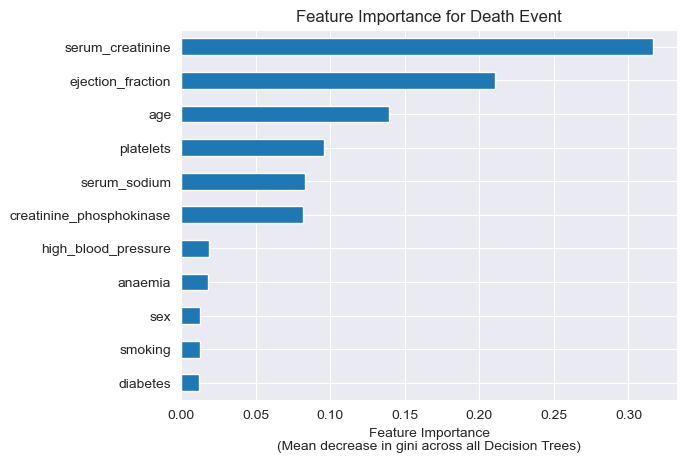

In [36]:
# create series of feature importance values
importances = list(rfc.feature_importances_)
importance_series = pd.Series(data=importances, index=new_feats)

# sort and plot features
importance_series = importance_series.sort_values()
importance_series.plot.barh()
plt.title('Feature Importance for Death Event')
plt.xlabel('Feature Importance\n(Mean decrease in gini across all Decision Trees)')
plt.show()

Removing time did not change the order of the ranking of the next 3 predictive features. The most predictive features, other than follow up period, were serum_creatinine (level of serum creatinine in the blood), ejection_fraction (percentage of blood leaving the heart at each contraction), and age.

#### Random Forest Model Accuracy: 88.03%
#### Accuracy excluding follow-up period: 79.99%
#### Most Predictive Features: Time (follow-up period), serum_creatinine (level of serum creatinine in the blood), ejection_fraction (percentage of blood leaving the heart at each contraction), and age.

## K-Nearest Neighbors

In [38]:
#divide the data into the input 'X' and the labels 'y'
# get list of feature names
x_feats = list(df.columns)
x_feats.remove('DEATH_EVENT')

X = df[x_feats]
y = df['DEATH_EVENT']

In [39]:
#particion data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

In [40]:
#build the K-NN classifier
knn = KNeighborsClassifier(n_neighbors = 5) #initialize the classifier and set the number of neighbors


knn.fit(X_train, y_train)

KNeighborsClassifier()

In [41]:
#predict the labels for the test set
y_pred   = knn.predict(X_test)

print('The predicted occurance of a death event is: {}'.format(y_pred))

The predicted occurance of a death event is: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]


In [42]:
#evaluate the prediction accuracy
print('The accuracy of the model is: {}'.format(knn.score(X_test, y_test)))

The accuracy of the model is: 0.6666666666666666


In [43]:
#reevaluate with different values of 

#identify a suitable value of k
predictions = {}

for k in range(3, 21, 2): #increment k by 2
    knn = KNeighborsClassifier(n_neighbors = k) #initialize the classifier and set the number of neighbors
    knn.fit(X_train, y_train)
    predictions[k] = knn.score(X_test, y_test)

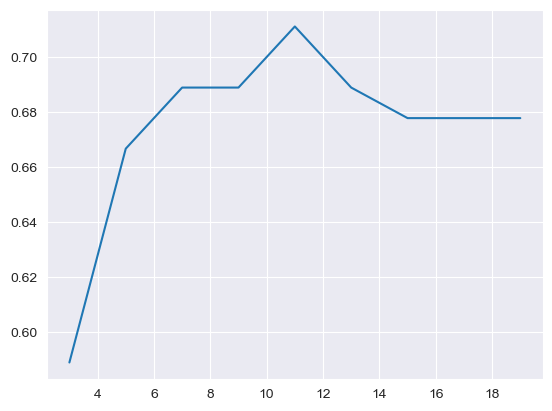

In [44]:
sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.show()

**Summary:** As the value of k increased the overall accuracy of the model decreased. When k=11, the model produced the highest accuracy on the test set at `71%`. Let's view the classification report to understand how to model predicts each label when k 11.

In [45]:
#get the classification report for the best value of k
knn_11 = KNeighborsClassifier(n_neighbors = 11) #initialize the classifier and set the number of neighbors
knn_11.fit(X_train, y_train)
y_pred = knn_11.predict(X_test)

target_names = ['death occurance', 'no death event']

print(classification_report(y_test, y_pred, target_names = target_names))

                 precision    recall  f1-score   support

death occurance       0.71      0.98      0.82        61
 no death event       0.80      0.14      0.24        29

       accuracy                           0.71        90
      macro avg       0.75      0.56      0.53        90
   weighted avg       0.74      0.71      0.63        90



**Explanation**: These classification reports are used to describe the precision and efficacy of when k=11. The precision is 0.71 for a death occurance. This means that there is `71%` correct positive predictions for these types. The precision for there being no death event is 0.80 meaning that the percentage of correct positive predictions for this event is `80%`. The recall for a death occurance showcases a percentage of `98%` correct positive predictions relative to total actual positives, where the occurance of no death event has `14%`. The f1-score showcases how accuarate the overall model was using the weighted mean of precision and recall to calculate. The F1 score for a death occurance was 0.82, which is close to 1, meaning that the model was `82%`. The F1 score for no death occurance however was only 0.24 which shows low accuracy. Overall the model accuracy rate when k=11 was `71%` meaning that is is relatively accurate with room for improvment. 

#### KNN Model Accuracy: 71%

## Summary

- SVM model accuracy: 79.38%
- KNN Model Accuracy: 71%
- Random Forest Model Accuracy: 88.03%
- Most Predictive Features: Time (follow-up period), serum_creatinine (level of serum creatinine in the blood), ejection_fraction (percentage of blood leaving the heart at each contraction), and age.

The random forest method had the highest model accuracy with 88.03%, making it a fairly successful model for predicting heart failure.